In [ ]:
! pip install kaggle

from google.colab import drive
drive.mount("/content/drive")


! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Classifier/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json


! kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder
! unzip stanford-car-dataset-by-classes-folder.zip

### Install Libraries and Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.applications import xception
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from glob import glob
from pathlib import Path
import os.path
import random
import matplotlib.cm as cm
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

##### Let's check images and get to know data

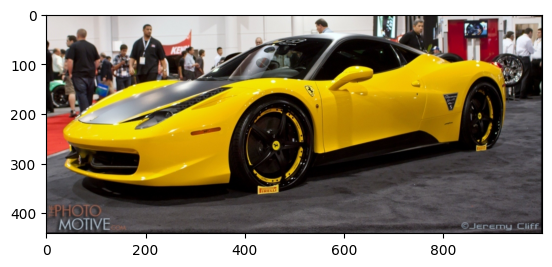

In [ ]:
test_path = "/content/car_data/car_data/test"
train_path = "/content/car_data/car_data/train"
car_data_path = "/content/car_data/car_data"

image = Image.open(train_path + "/Ferrari 458 Italia Coupe 2012/00293.jpg")
imgplot = plt.imshow(image)
plt.show()

In [ ]:
print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))

196
196


In [ ]:
categories = os.listdir(train_path)
num_of_categories = len(categories)
car_list = sorted(os.listdir(train_path))
car_list[:3]

print("Counts of Models = {}".format(num_of_categories))

Counts of Models = 196


In [ ]:
model_count_graph = pd.DataFrame(
    index = [i for i in categories],
    data = [len(os.listdir(train_path + "/" + name))
              for name in categories],
    columns = ["number of images"]
)

model_count_graph.sort_values(by = "number of images" , ascending = False)

,number of images
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mitsubishi Lancer Sedan 2012,48
Mercedes-Benz 300-Class Convertible 1993,48
Chevrolet Corvette ZR1 2012,47
...,...
Rolls-Royce Phantom Drophead Coupe Convertible 2012,31
Chevrolet Express Cargo Van 2007,30
Maybach Landaulet Convertible 2012,29
FIAT 500 Abarth 2012,28


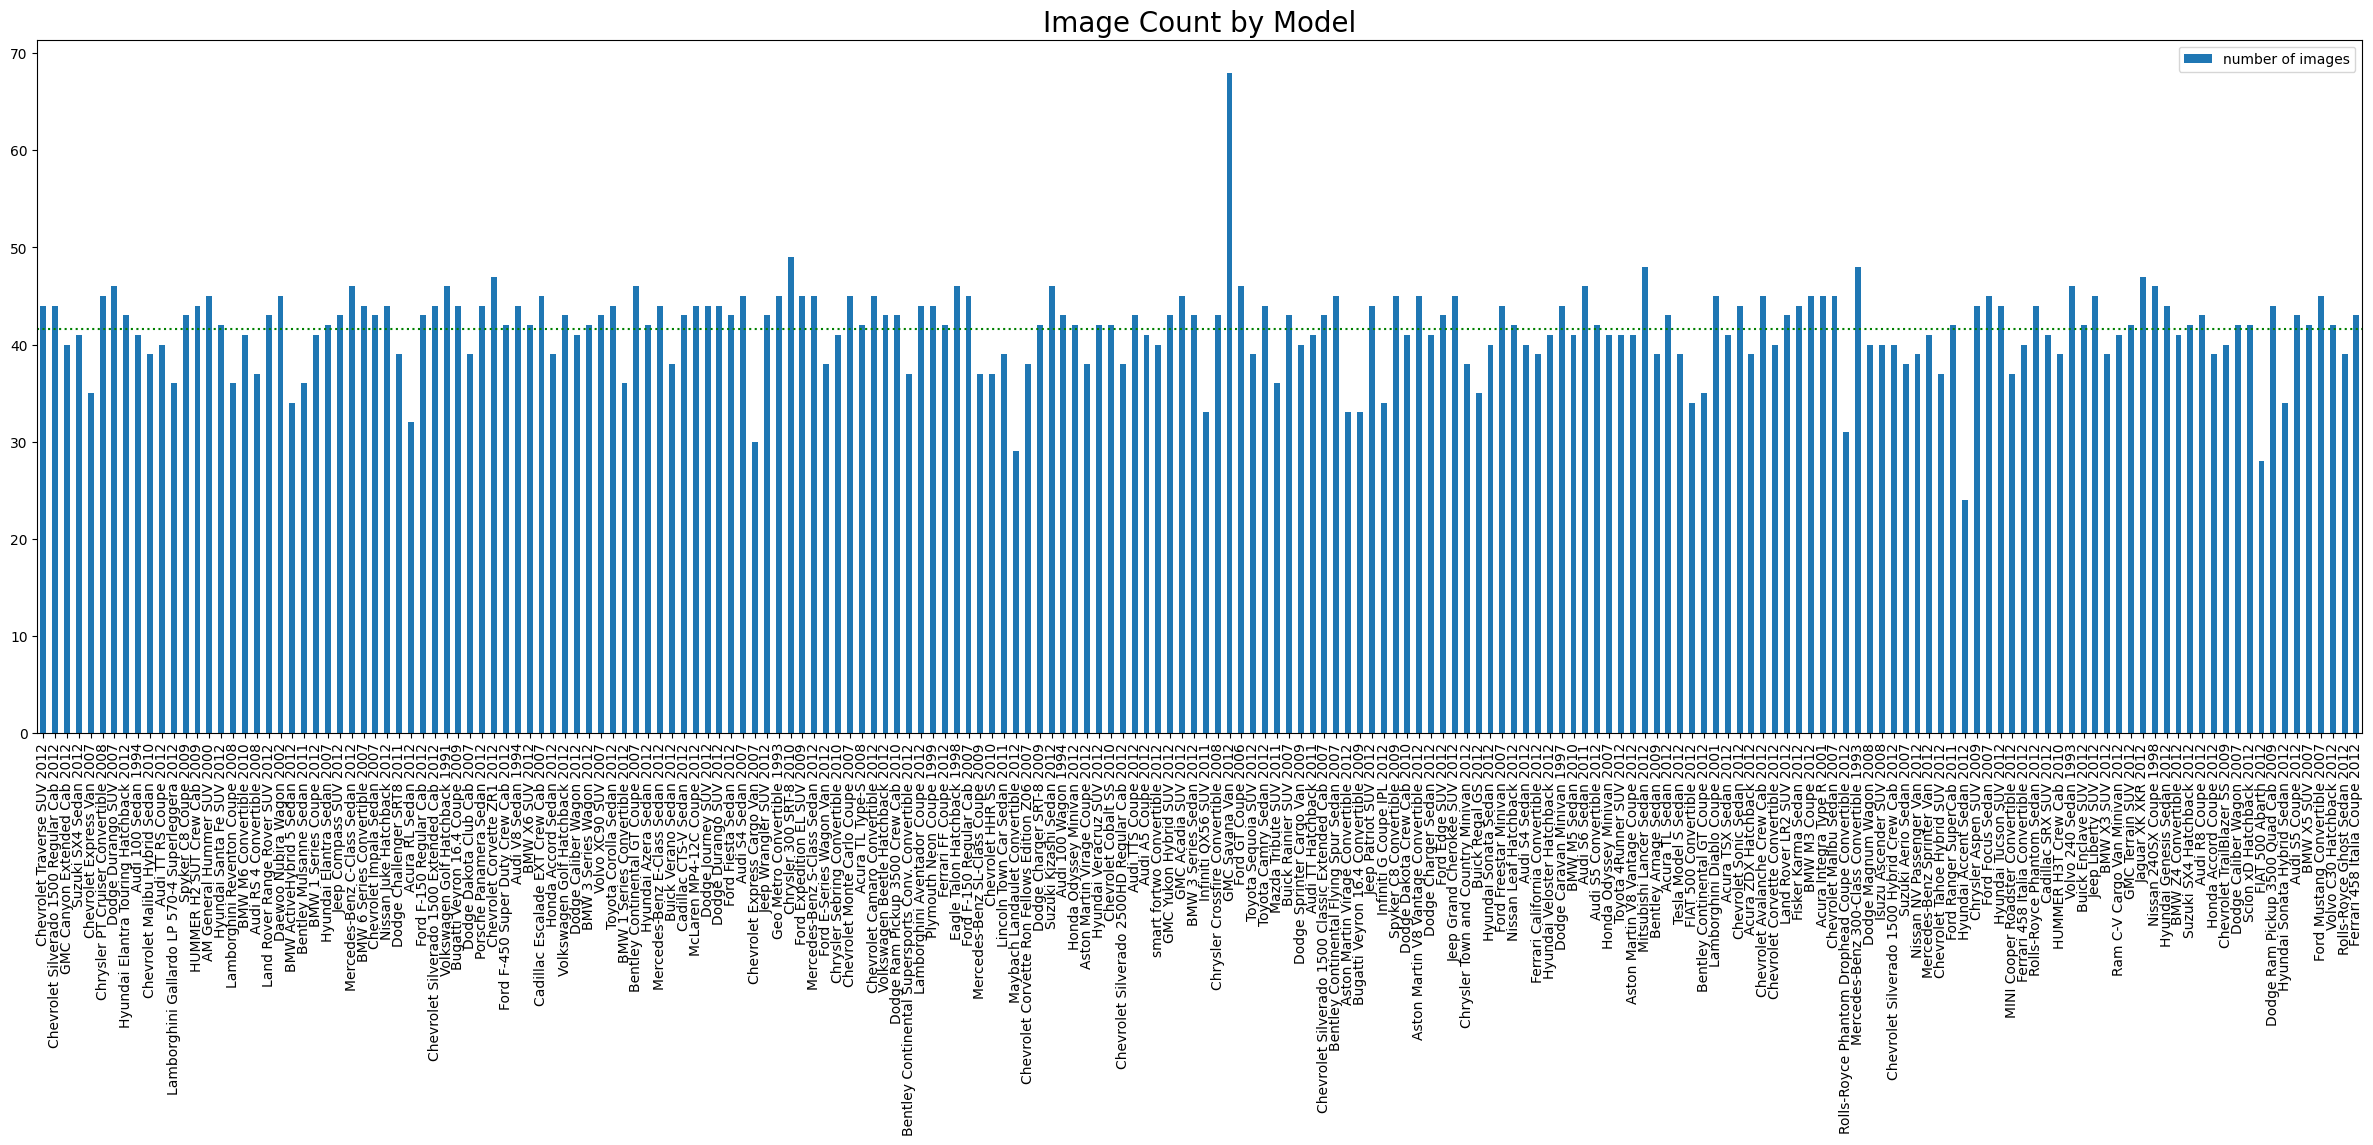

Mean Value of All Model Numbers : 41.55102040816327


In [ ]:
fig = model_count_graph.plot(kind = "bar", figsize = (30,9))
mean_of_pictures = model_count_graph["number of images"].mean()
fig.axhline(mean_of_pictures, color = "g", linestyle = ":", label = "Mean of Pictures")
plt.title("Image Count by Model", fontsize = 20)
plt.show()
print("Mean Value of All Model Numbers :", mean_of_pictures)

##### As you can see, we have 196 classes, with an average of 41.5 images per class. This is a very low number, so it will create very serious problems for the model we will create. In such a case, we can resort to ways such as data augmentation and synthetic data generation. In this study, synthetic data generation will be applied.

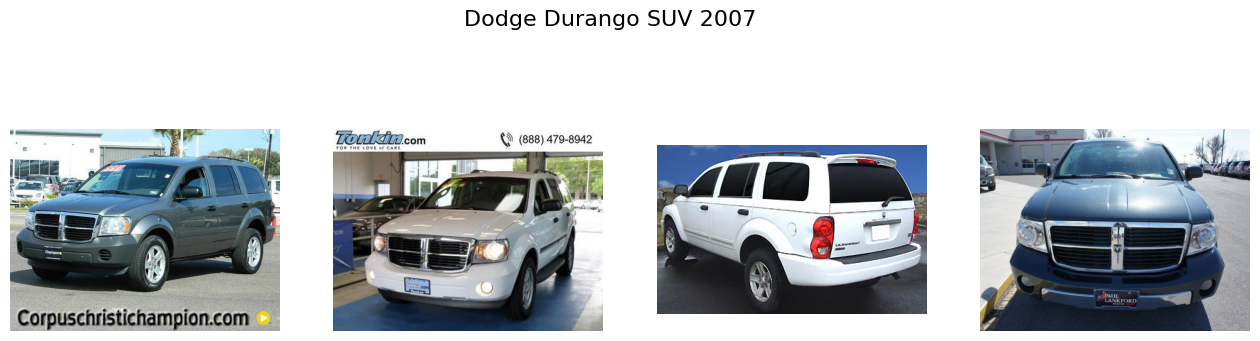

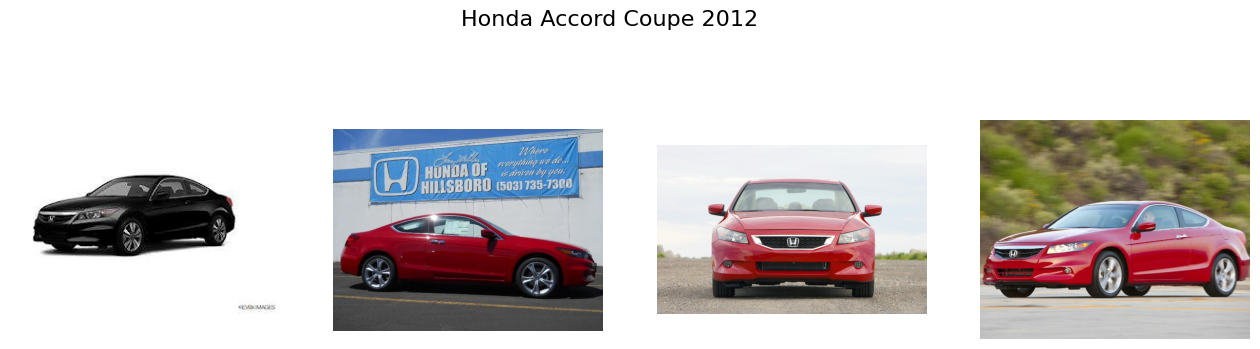

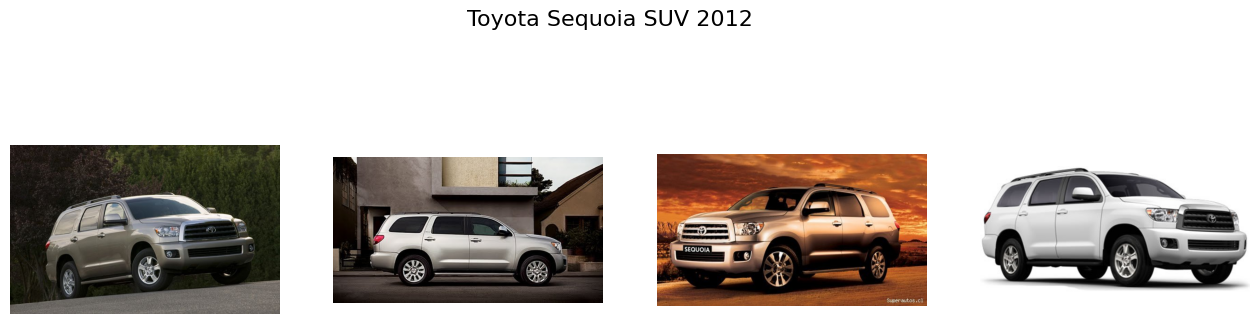

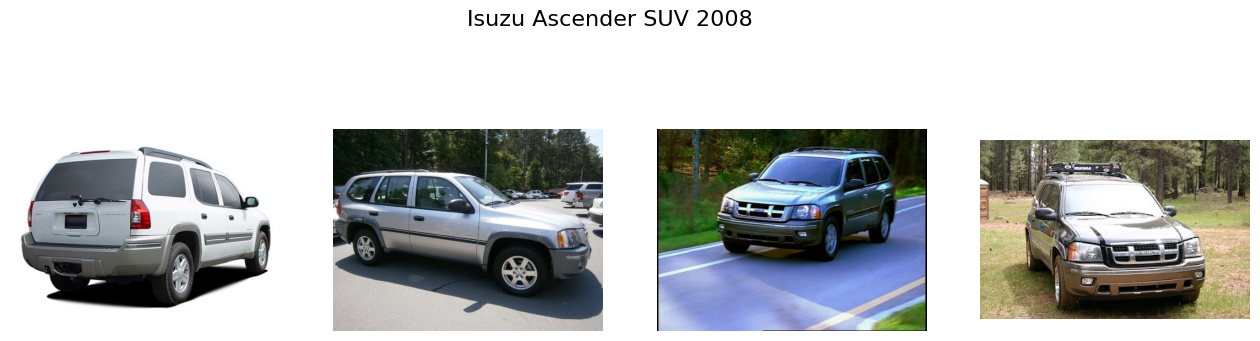

In [ ]:
def image_show(path, classes):
  fig = plt.figure(figsize=(16, 8))
  fig.patch.set_facecolor('white')
  plt.suptitle("{}".format(classes),
                 color="black", fontsize=16)
  image = os.listdir(path + "/" + classes)[:4]

  for i in range(4):
    img = plt.imread(path + "/" + classes + "/" + image[i])
    plt.subplot(int(4/4+1), 4 , i+1)
    plt.imshow(img)
    plt.axis('off')
  plt.show()

for i in np.random.randint(0, len(categories), size = 4):
    image_show(train_path, categories[i])

##### Setting up the hyperparameters

In [ ]:
img_height, img_width = 224, 224
image_size = [224, 224]
num_classes = 196
batch_size = 32
num_epochs = 8

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Synthetic Data Generation

In [ ]:
if not os.path.exists('synthetic_data'):
    os.makedirs('synthetic_data')

synthetic_data_dir = 'synthetic_data'
for class_folder in os.listdir(train_path):
    class_path = os.path.join(train_path, class_folder)
    synthetic_class_path = os.path.join(synthetic_data_dir, class_folder)

    if not os.path.exists(synthetic_class_path):
        os.makedirs(synthetic_class_path)

    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    num_existing_images = len(image_files)

    if num_existing_images < 120:
        num_synthetic_images = 120 - num_existing_images

        for i in range(num_synthetic_images):
            # Select a random image from the existing data
            random_image_file = np.random.choice(image_files)
            random_image_path = os.path.join(class_path, random_image_file)

            # Load the random image using OpenCV
            image = cv2.imread(random_image_path)

            # Apply data augmentation
            augmented_image = train_datagen.random_transform(image)

            # Save the augmented image with a new name
            augmented_image_name = f"synthetic_{i+1}_{random_image_file}"
            augmented_image_path = os.path.join(synthetic_class_path, augmented_image_name)
            cv2.imwrite(augmented_image_path, augmented_image)

##### Let's check the data distribution again

In [ ]:
categories = os.listdir(synthetic_data_dir)
num_of_categories = len(categories)
car_list = sorted(os.listdir(synthetic_data_dir))
car_list[:3]

print("Counts of Models = {}".format(num_of_categories))

Counts of Models = 196


In [ ]:
model_count_graph = pd.DataFrame(
    index = [i for i in categories],
    data = [len(os.listdir(synthetic_data_dir + "/" + name))
              for name in categories],
    columns = ["number of images"]
)

model_count_graph.sort_values(by = "number of images" , ascending = False)

,number of images
Hyundai Accent Sedan 2012,96
FIAT 500 Abarth 2012,92
Maybach Landaulet Convertible 2012,91
Chevrolet Express Cargo Van 2007,90
Rolls-Royce Phantom Drophead Coupe Convertible 2012,89
...,...
Jaguar XK XKR 2012,73
Mercedes-Benz 300-Class Convertible 1993,72
Mitsubishi Lancer Sedan 2012,72
Chrysler 300 SRT-8 2010,71


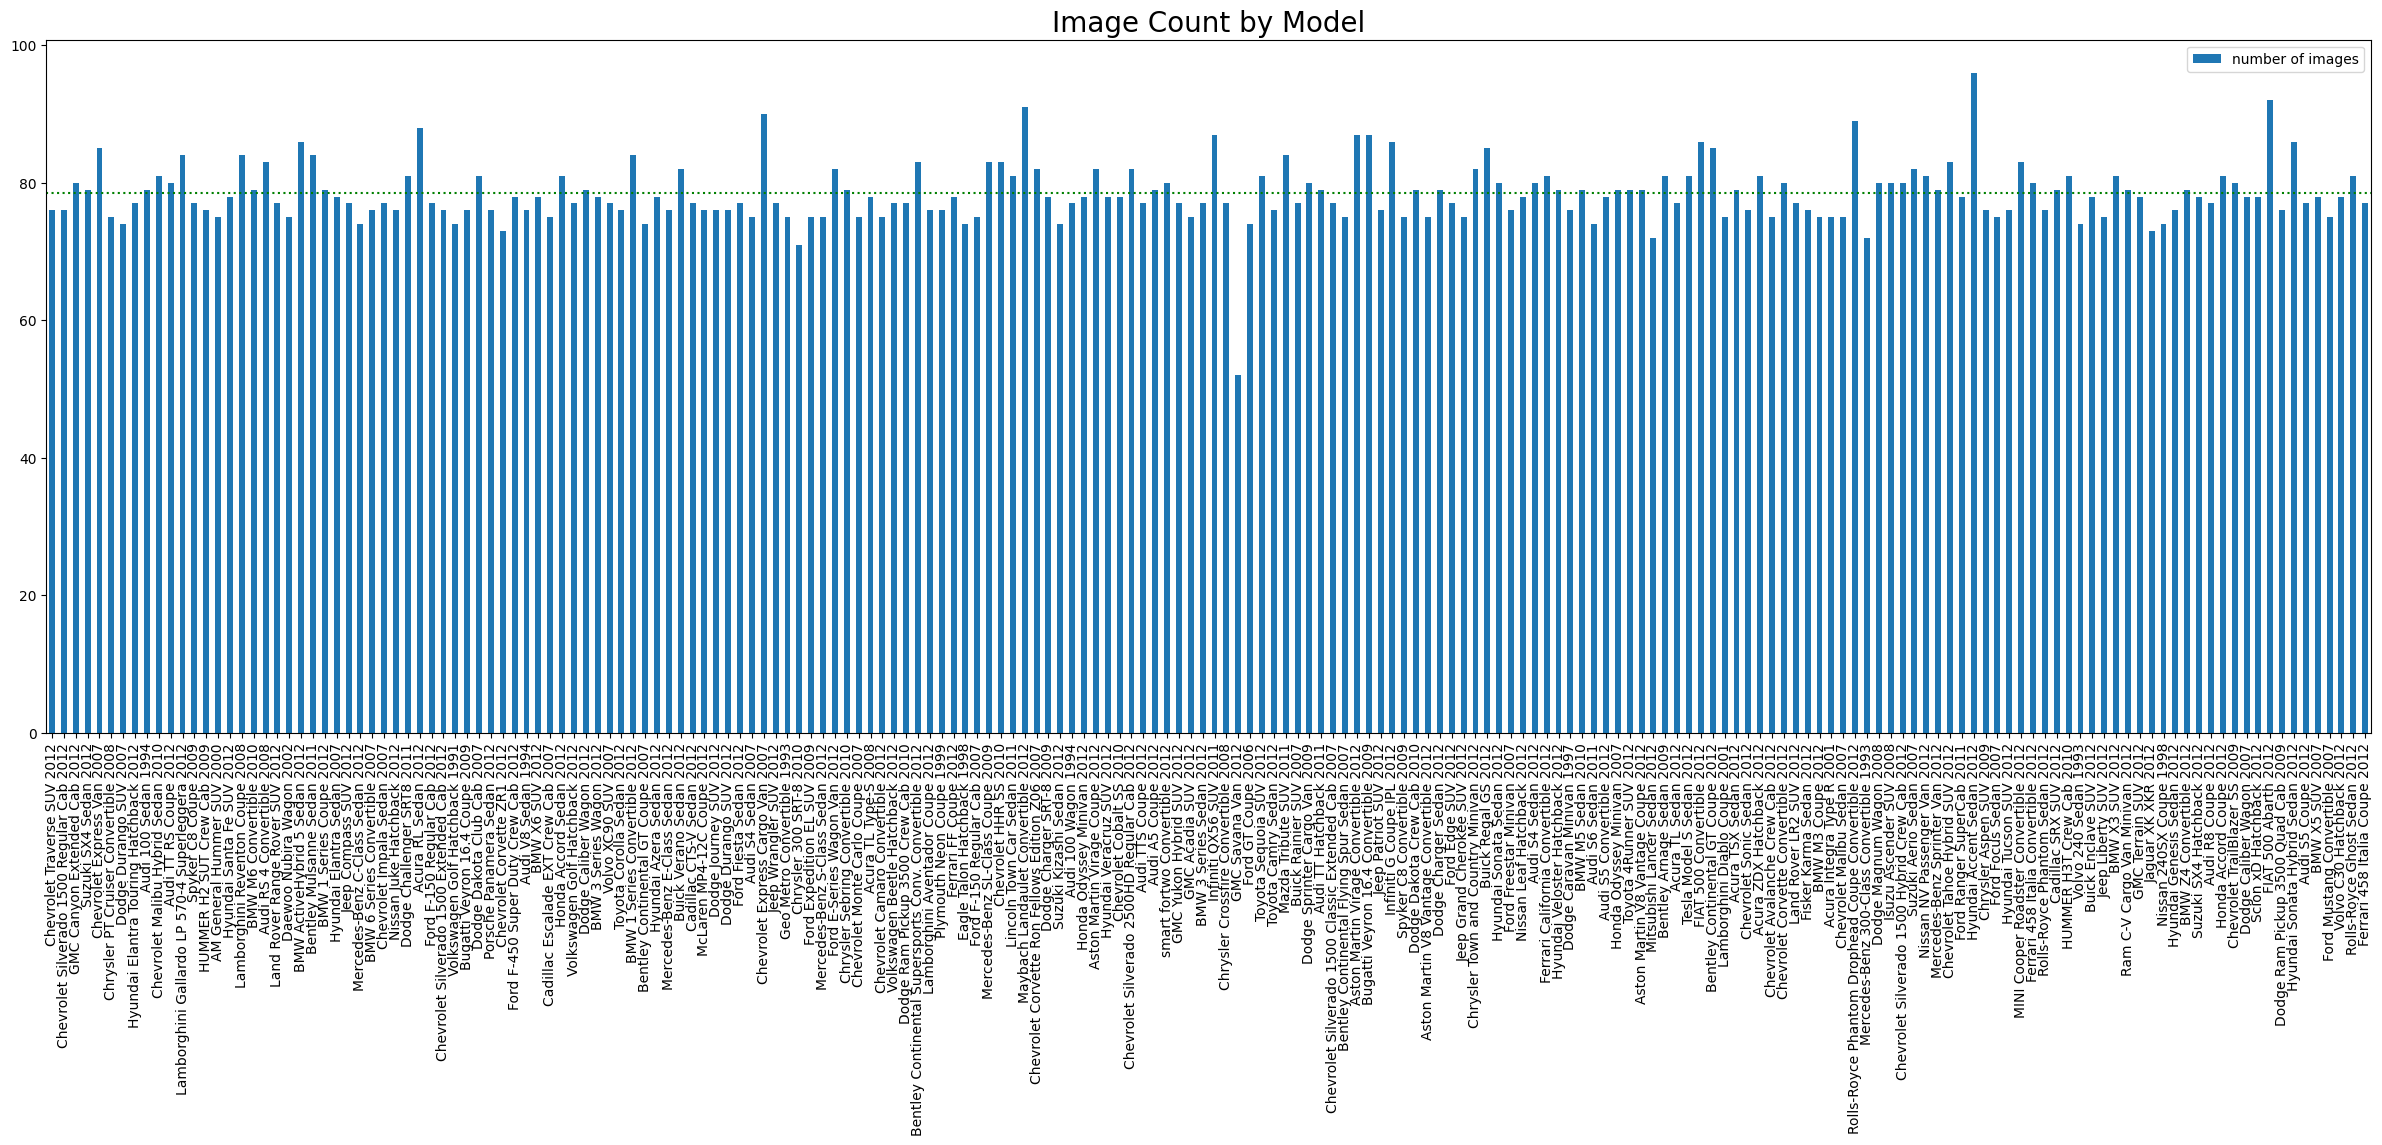

Mean Value of All Model Numbers : 78.44897959183673


In [ ]:
fig = model_count_graph.plot(kind = "bar", figsize = (30,9))
mean_of_pictures = model_count_graph["number of images"].mean()
fig.axhline(mean_of_pictures, color = "g", linestyle = ":", label = "Mean of Pictures")
plt.title("Image Count by Model", fontsize = 20)
plt.show()
print("Mean Value of All Model Numbers :", mean_of_pictures)

##### As you can see, the average number of images increased from 41.5 to 78.4. Again, this is a very low number for such a classification project. However, we will not focus on that today because the goal here was to show how to implement synthetic data generation. Below you can see the success of the DenseNet121 model.

In [ ]:
training_set = train_datagen.flow_from_directory(synthetic_data_dir, target_size=(img_height, img_width), batch_size=batch_size)
test_set = test_datagen.flow_from_directory(test_path, target_size=(img_height, img_width), batch_size=batch_size)

# Load DenseNet-101 without the top (fully connected) layers
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3), pooling=None)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base DenseNet-101 model with custom top layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(training_set, validation_data=test_set, epochs=num_epochs, steps_per_epoch=len(training_set), validation_steps=len(test_set))

# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Found 15376 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
Epoch 1/20
241/241 [==============================] - 248s 1s/step - loss: 5.0252 - accuracy: 0.0453 - val_loss: 4.3949 - val_accuracy: 0.1046
Epoch 2/20
241/241 [==============================] - 241s 1s/step - loss: 4.0889 - accuracy: 0.1607 - val_loss: 3.8346 - val_accuracy: 0.1777
Epoch 3/20
241/241 [==============================] - 242s 1s/step - loss: 3.5698 - accuracy: 0.2430 - val_loss: 3.5081 - val_accuracy: 0.2252
Epoch 4/20
241/241 [==============================] - 241s 1s/step - loss: 3.2269 - accuracy: 0.3127 - val_loss: 3.3257 - val_accuracy: 0.2643
Epoch 5/20
241/241 [==============================] - 243s 1s/step - loss: 2.9813 - accuracy: 0.3655 - val_loss: 3.1996 - val_accuracy: 0.2699
Epoch 6/20
241/241 [==============================] - 243s 1s/step - loss: 2.7917 - accuracy: 0.3937 - val_loss: 3.0616 - val_accuracy: 0.2991
Epoch 7/20
241/241 [==============================] -